# Präsenzversuch zum Laval-Rotor

Name: Christoph Fröhlich
Datum: 03.02.24
Gruppe: 48

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: Wie nah liegen die kritischen Drehzahlen des theoretisch und experimentell ermittelten Wertes beieinander?

## Erster Versuch: Prüfstand #X
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="prüfstand3.jpeg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein: Es wird eine Welle mit einer angebrachten Drehscheibe über einen Elektromotor angetrieben und die Drehzahl über die Zeit stetig erhöht.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_pruefstand3"
)  # path to the folder with H5-file and metadata
filename = "data_20240115_105207_lavalrotor_48_03.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_pruefstand3/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_pruefstand3/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_pruefstand3/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_pruefstand3/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -4,
      "max": 4,
      "un

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
# Messdaten aus der H5-Datei auslesen
data_list = m_postprocessing.get_data(path_measurement_folder + "/" +filename, uuid_acceleration, uuid_motor_rpm)

# Interpolationszeitpunkte festlegen
interpolation_points = m_postprocessing.get_interpolation_points(data_list)

In [5]:
file_path = os.path.join(path_measurement_folder, filename)
x_np = []
y_np = []
z_np = []
time_np = []
motor_rpm = []


with h5py.File(file_path, "r") as hdf_file:
    # Über Items iterieren
    for group_name, group in hdf_file.items():
        # Über Datensätze iterieren
        for dataset_name, dataset in group.items():
            for uuid, uuid_dataset in dataset.items():
                if uuid == uuid_acceleration:
                    for uuid_obj, uuid_obj_data in uuid_dataset.items():
                        values = np.array(uuid_obj_data)
                        if uuid_obj == "acceleration_x":
                            x_np.append(values)
                        elif uuid_obj == "acceleration_y":
                            y_np.append(values)
                        elif uuid_obj == "acceleration_z":
                            z_np.append(values)
                        elif uuid_obj == "timestamp":
                            time_np.append(values)
                if uuid == uuid_motor_rpm:
                    for uuid_obj, uuid_obj_data in uuid_dataset.items():
                        values = np.array(uuid_obj_data)
                        motor_rpm.append(values)     
                continue

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing) # Funktionen erneut laden

# Interpolation der Beschleunigungsbeträge
data_list_2 = []
for i in range(len(data_list)):
    inter_data = m_postprocessing.interpolation(data_list[i][3], m_postprocessing.get_vec_accel(data_list[i][0], data_list[i][1], data_list[i][2]), interpolation_points)
    data_list_2.append([inter_data, interpolation_points, data_list[i][4]])

# rfft_scaled
data_list_3 = []
for i in range(len(data_list_2)):
    rfft_scaled = m_postprocessing.my_fft_scaled(data_list_2[i][0], data_list_2[i][1])
    data_list_3.append([rfft_scaled[0], rfft_scaled[1], data_list[i][4]])    #append([fft-Amplituden,fft-Frequenzen,Drehzahl])

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

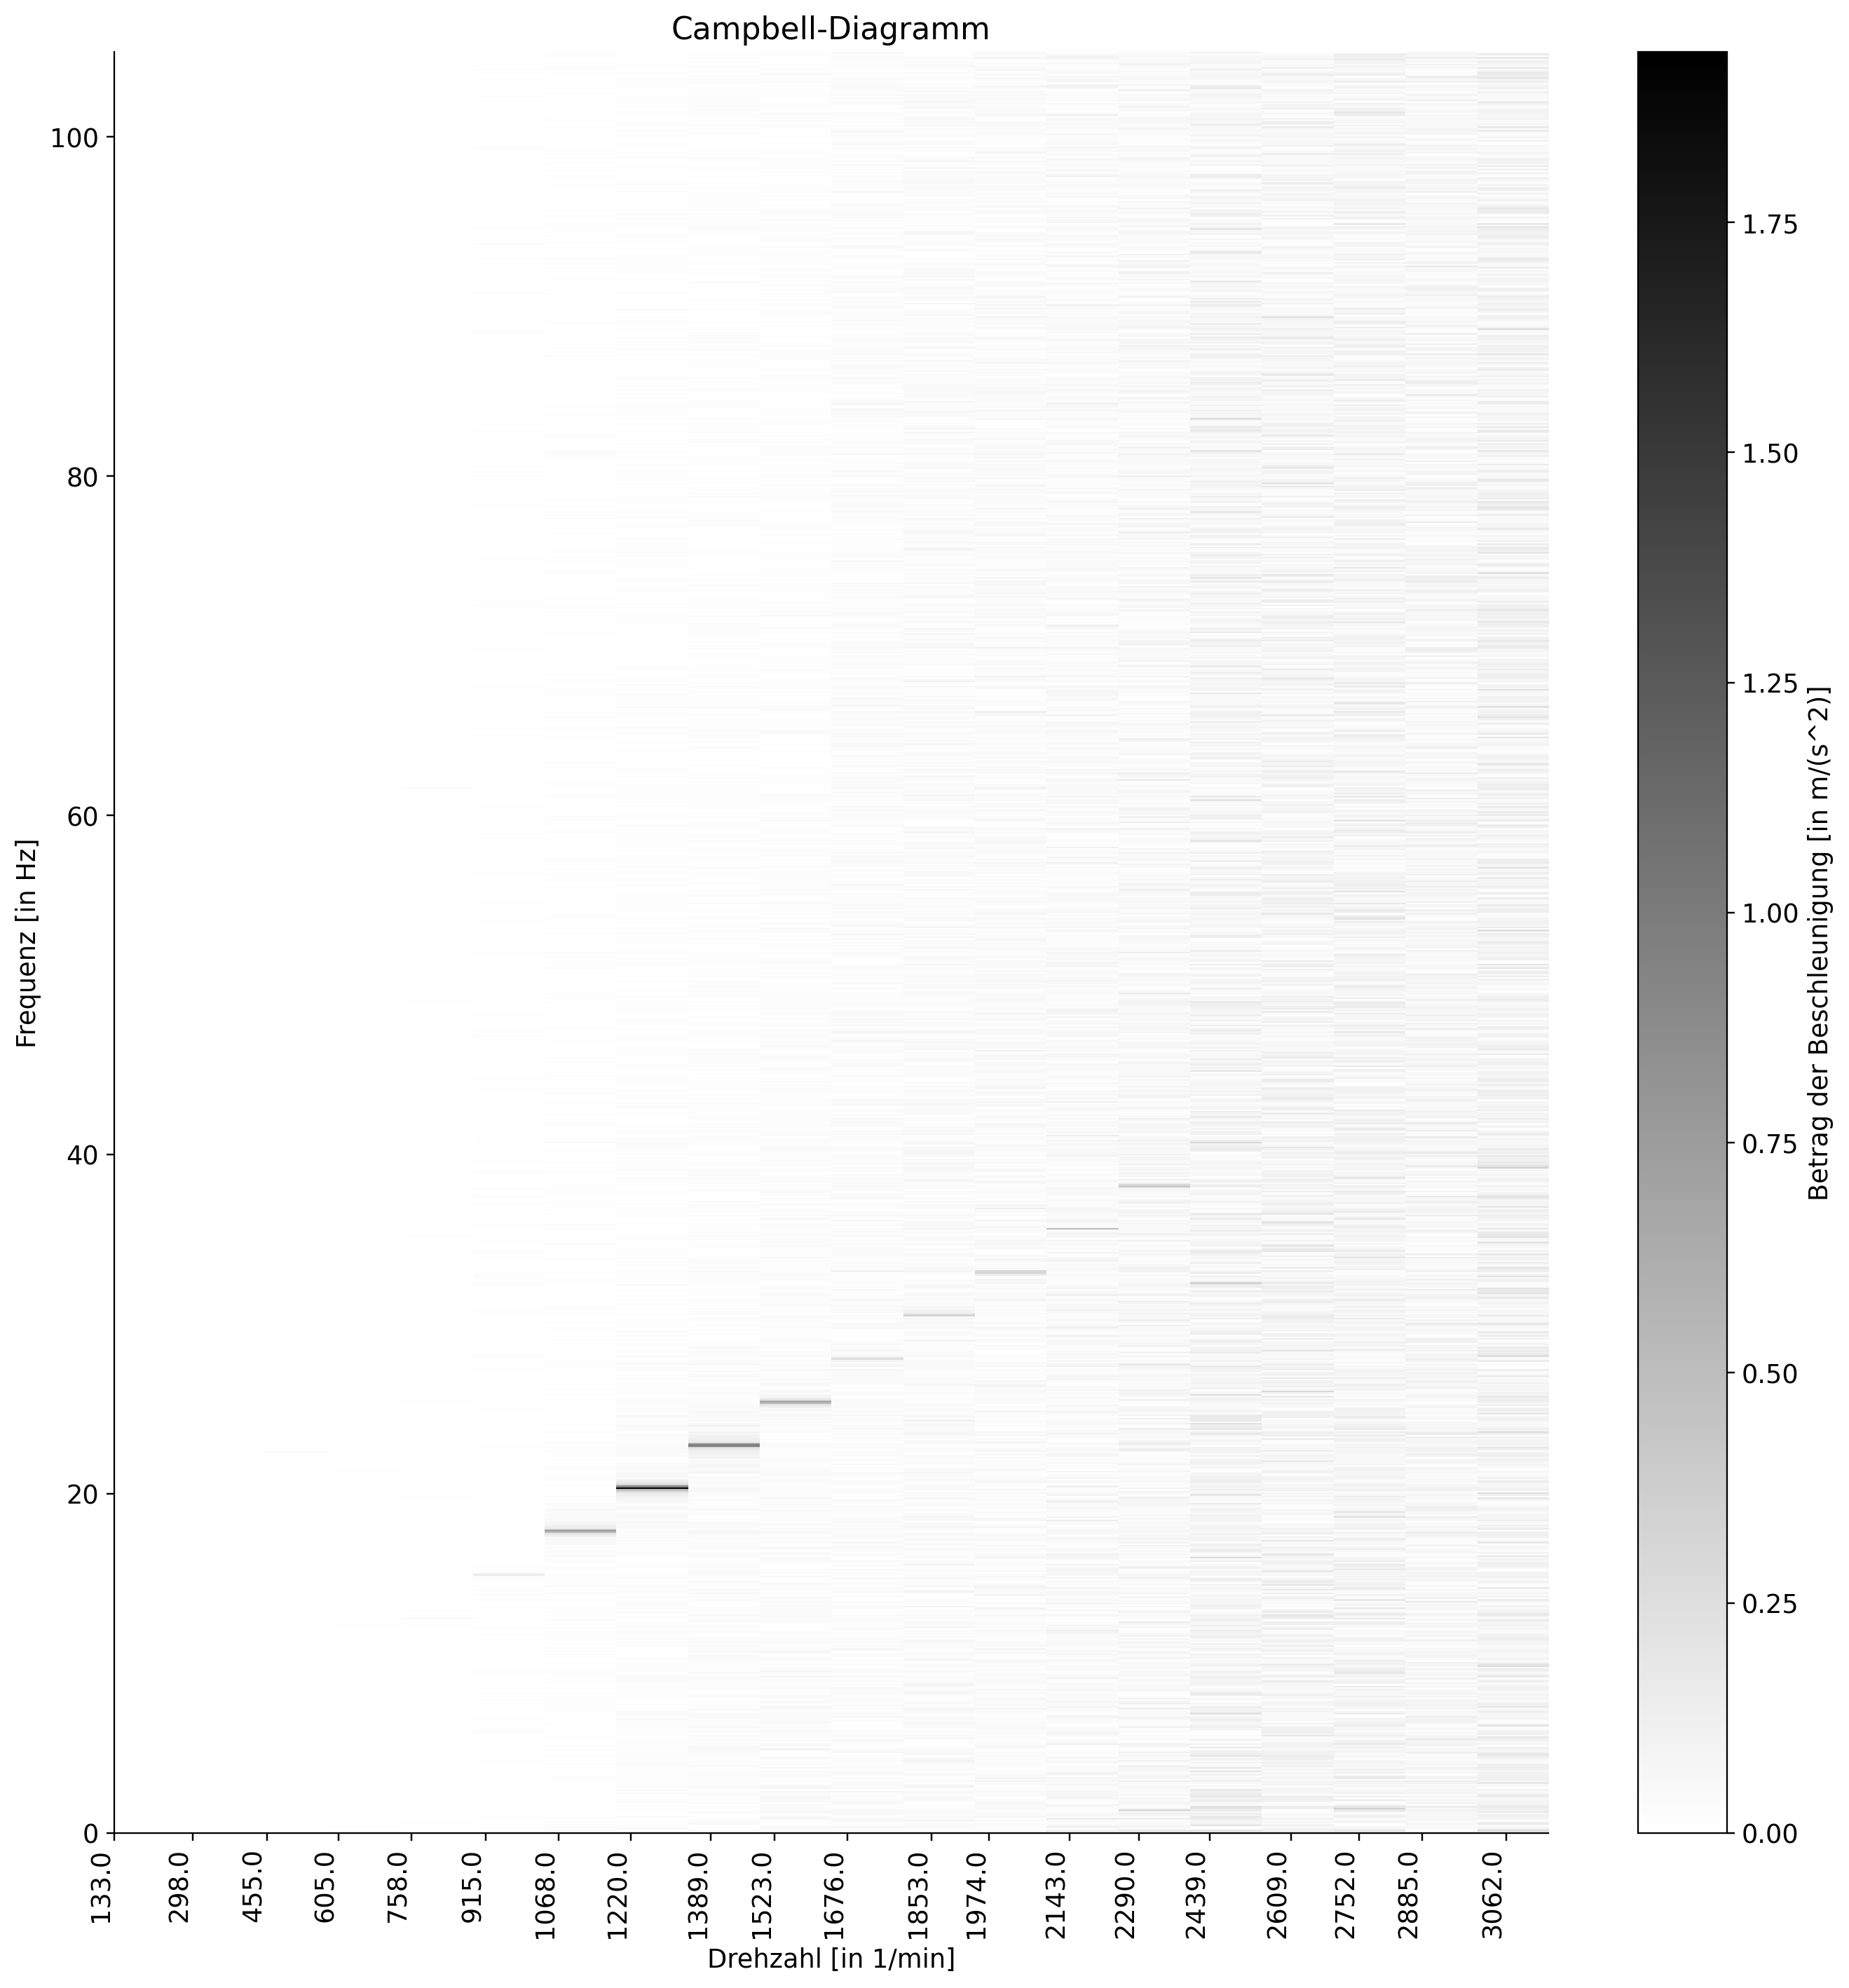

In [7]:
matrix = np.empty((len(data_list_3[1][1]),len(data_list_3)))
x_list = []
y_list = data_list_3[0][1]      

for i in range(len(data_list_3)):
    x_list.append(float(data_list_3[i][2]))
    for a in range(len(data_list_3[i][0])):
        matrix[a,i] = np.abs(data_list_3[i][0][a])
        
# Campbell-Diagramm plotten

fig, ax = plt.subplots(figsize=(15, 15))

extent = (min(x_list), x_list[-1] + (x_list[-1]-x_list[-2])/2, min(y_list), max(y_list))

plt.imshow(matrix,origin="lower", aspect="auto",interpolation="None",extent=extent,cmap="binary", vmin=matrix.min() ,vmax=matrix.max())

ax.set_xticks(x_list)
ax.set_xticklabels(x_list, rotation=90, ha='right')

plt.xlabel('Drehzahl [in 1/min]')
plt.ylabel('Frequenz [in Hz]')
plt.title("Campbell-Diagramm")
cbar=plt.colorbar()
cbar.set_label('Betrag der Beschleunigung [in m/(s^2)]')
plt.show()

## Zweiter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

# Messdaten aus der H5-Datei auslesen
data_list = m_postprocessing.get_data(path_measurement_folder + "/" +filename, uuid_acceleration, uuid_motor_rpm)

# Interpolationszeitpunkte festlegen
interpolation_points = m_postprocessing.get_interpolation_points(data_list)

file_path = os.path.join(path_measurement_folder, filename)
x_np = []
y_np = []
z_np = []
time_np = []
motor_rpm = []


with h5py.File(file_path, "r") as hdf_file:
    # Über Items iterieren
    for group_name, group in hdf_file.items():
        # Über Datensätze iterieren
        for dataset_name, dataset in group.items():
            for uuid, uuid_dataset in dataset.items():
                if uuid == uuid_acceleration:
                    for uuid_obj, uuid_obj_data in uuid_dataset.items():
                        values = np.array(uuid_obj_data)
                        if uuid_obj == "acceleration_x":
                            x_np.append(values)
                        elif uuid_obj == "acceleration_y":
                            y_np.append(values)
                        elif uuid_obj == "acceleration_z":
                            z_np.append(values)
                        elif uuid_obj == "timestamp":
                            time_np.append(values)
                if uuid == uuid_motor_rpm:
                    for uuid_obj, uuid_obj_data in uuid_dataset.items():
                        values = np.array(uuid_obj_data)
                        motor_rpm.append(values)     
                continue

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [9]:
importlib.reload(m_postprocessing) # Funktionen erneut laden

# Interpolation der Beschleunigungsbeträge
data_list_2 = []
for i in range(len(data_list)):
    inter_data = m_postprocessing.interpolation(data_list[i][3], m_postprocessing.get_vec_accel(data_list[i][0], data_list[i][1], data_list[i][2]), interpolation_points)
    data_list_2.append([inter_data, interpolation_points, data_list[i][4]])

# rfft_scaled
data_list_3 = []
for i in range(len(data_list_2)):
    rfft_scaled = m_postprocessing.my_fft_scaled(data_list_2[i][0], data_list_2[i][1])
    data_list_3.append([rfft_scaled[0], rfft_scaled[1], data_list[i][4]])    #append([fft-Amplituden,fft-Frequenzen,Drehzahl])

#### 3. Darstellung mittels Campbell-Diagramm

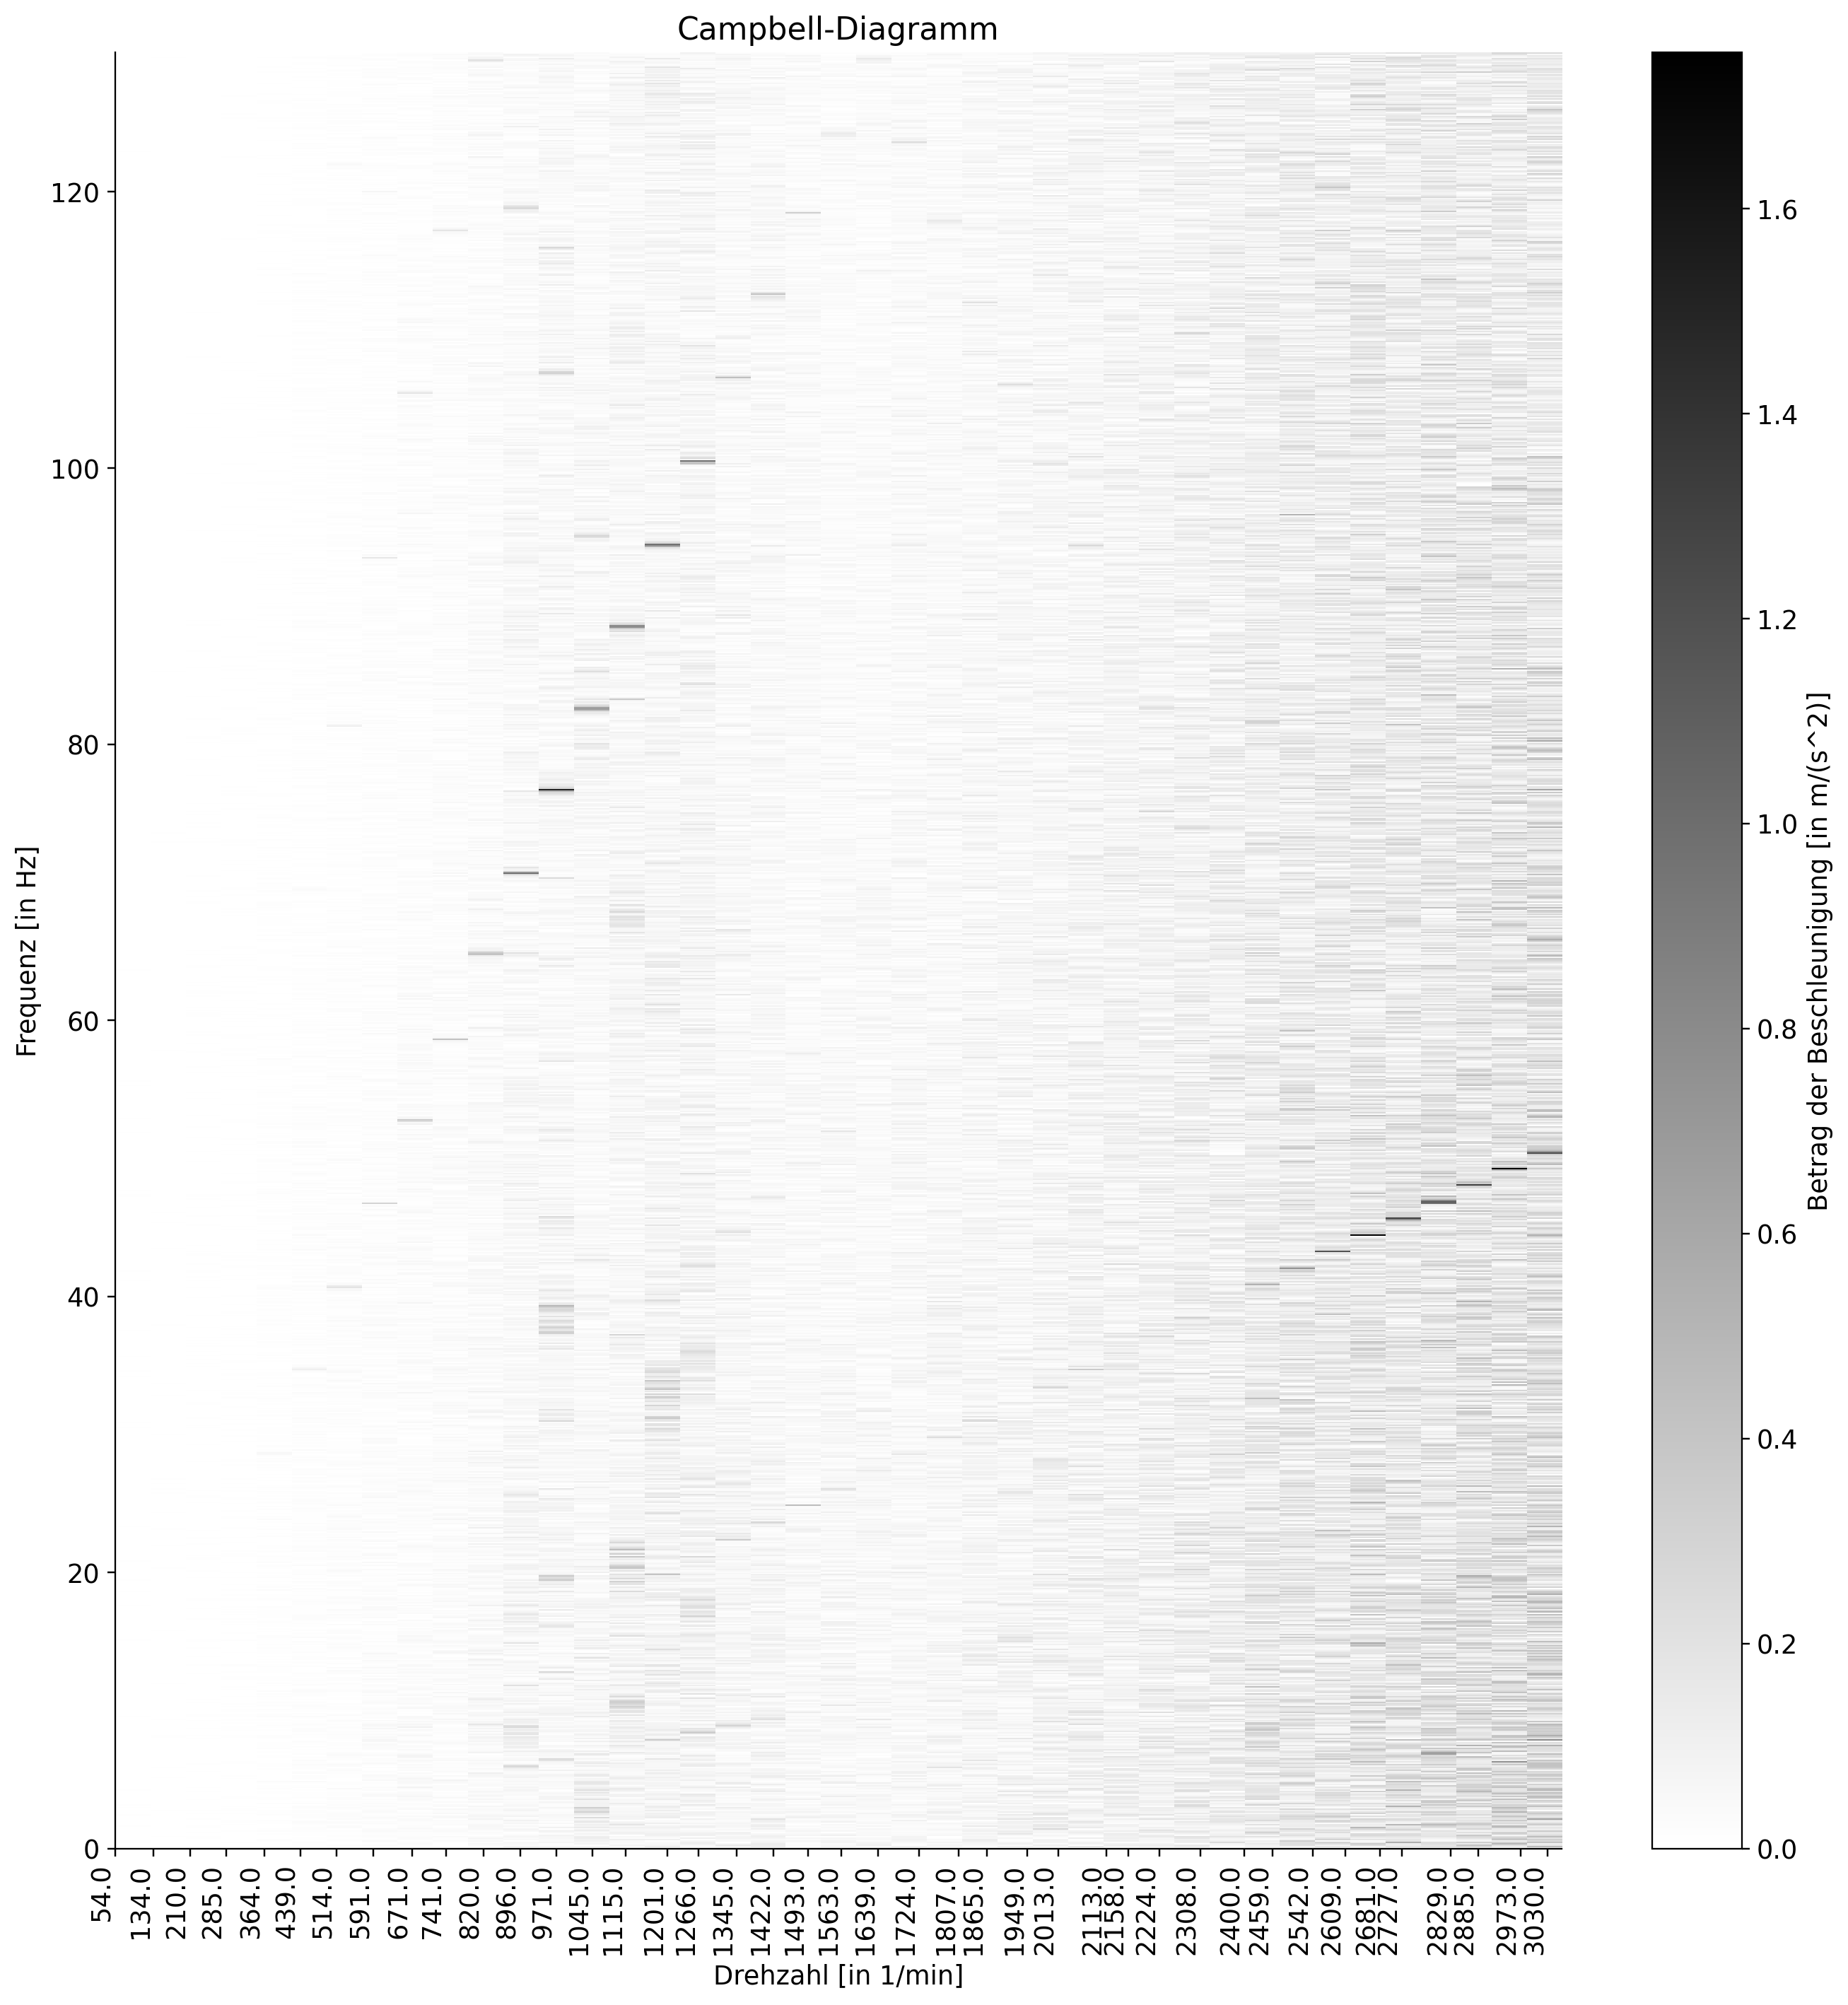

In [10]:
matrix = np.empty((len(data_list_3[1][1]),len(data_list_3)))
x_list = []
y_list = data_list_3[0][1]      

for i in range(len(data_list_3)):
    x_list.append(float(data_list_3[i][2]))
    for a in range(len(data_list_3[i][0])):
        matrix[a,i] = np.abs(data_list_3[i][0][a])
        
# Campbell-Diagramm plotten

fig, ax = plt.subplots(figsize=(15, 15))

extent = (min(x_list), x_list[-1] + (x_list[-1]-x_list[-2])/2, min(y_list), max(y_list))

plt.imshow(matrix,origin="lower", aspect="auto",interpolation="None",extent=extent,cmap="binary", vmin=matrix.min() ,vmax=matrix.max())

ax.set_xticks(x_list)
ax.set_xticklabels(x_list, rotation=90, ha='right')

plt.xlabel('Drehzahl [in 1/min]')
plt.ylabel('Frequenz [in Hz]')
plt.title("Campbell-Diagramm")
cbar=plt.colorbar()
cbar.set_label('Betrag der Beschleunigung [in m/(s^2)]')
plt.show()

## Dritter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [11]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240109_104244_lavalrotor_01_04.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

# Messdaten aus der H5-Datei auslesen
data_list = m_postprocessing.get_data(path_measurement_folder + "/" +filename, uuid_acceleration, uuid_motor_rpm)

# Interpolationszeitpunkte festlegen
interpolation_points = m_postprocessing.get_interpolation_points(data_list)

file_path = os.path.join(path_measurement_folder, filename)
x_np = []
y_np = []
z_np = []
time_np = []
motor_rpm = []


with h5py.File(file_path, "r") as hdf_file:
    # Über Items iterieren
    for group_name, group in hdf_file.items():
        # Über Datensätze iterieren
        for dataset_name, dataset in group.items():
            for uuid, uuid_dataset in dataset.items():
                if uuid == uuid_acceleration:
                    for uuid_obj, uuid_obj_data in uuid_dataset.items():
                        values = np.array(uuid_obj_data)
                        if uuid_obj == "acceleration_x":
                            x_np.append(values)
                        elif uuid_obj == "acceleration_y":
                            y_np.append(values)
                        elif uuid_obj == "acceleration_z":
                            z_np.append(values)
                        elif uuid_obj == "timestamp":
                            time_np.append(values)
                if uuid == uuid_motor_rpm:
                    for uuid_obj, uuid_obj_data in uuid_dataset.items():
                        values = np.array(uuid_obj_data)
                        motor_rpm.append(values)     
                continue

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [12]:
importlib.reload(m_postprocessing) # Funktionen erneut laden

# Interpolation der Beschleunigungsbeträge
data_list_2 = []
for i in range(len(data_list)):
    inter_data = m_postprocessing.interpolation(data_list[i][3], m_postprocessing.get_vec_accel(data_list[i][0], data_list[i][1], data_list[i][2]), interpolation_points)
    data_list_2.append([inter_data, interpolation_points, data_list[i][4]])

# rfft_scaled
data_list_3 = []
for i in range(len(data_list_2)):
    rfft_scaled = m_postprocessing.my_fft_scaled(data_list_2[i][0], data_list_2[i][1])
    data_list_3.append([rfft_scaled[0], rfft_scaled[1], data_list[i][4]])    #append([fft-Amplituden,fft-Frequenzen,Drehzahl])

#### 3. Darstellung mittels Campbell-Diagramm

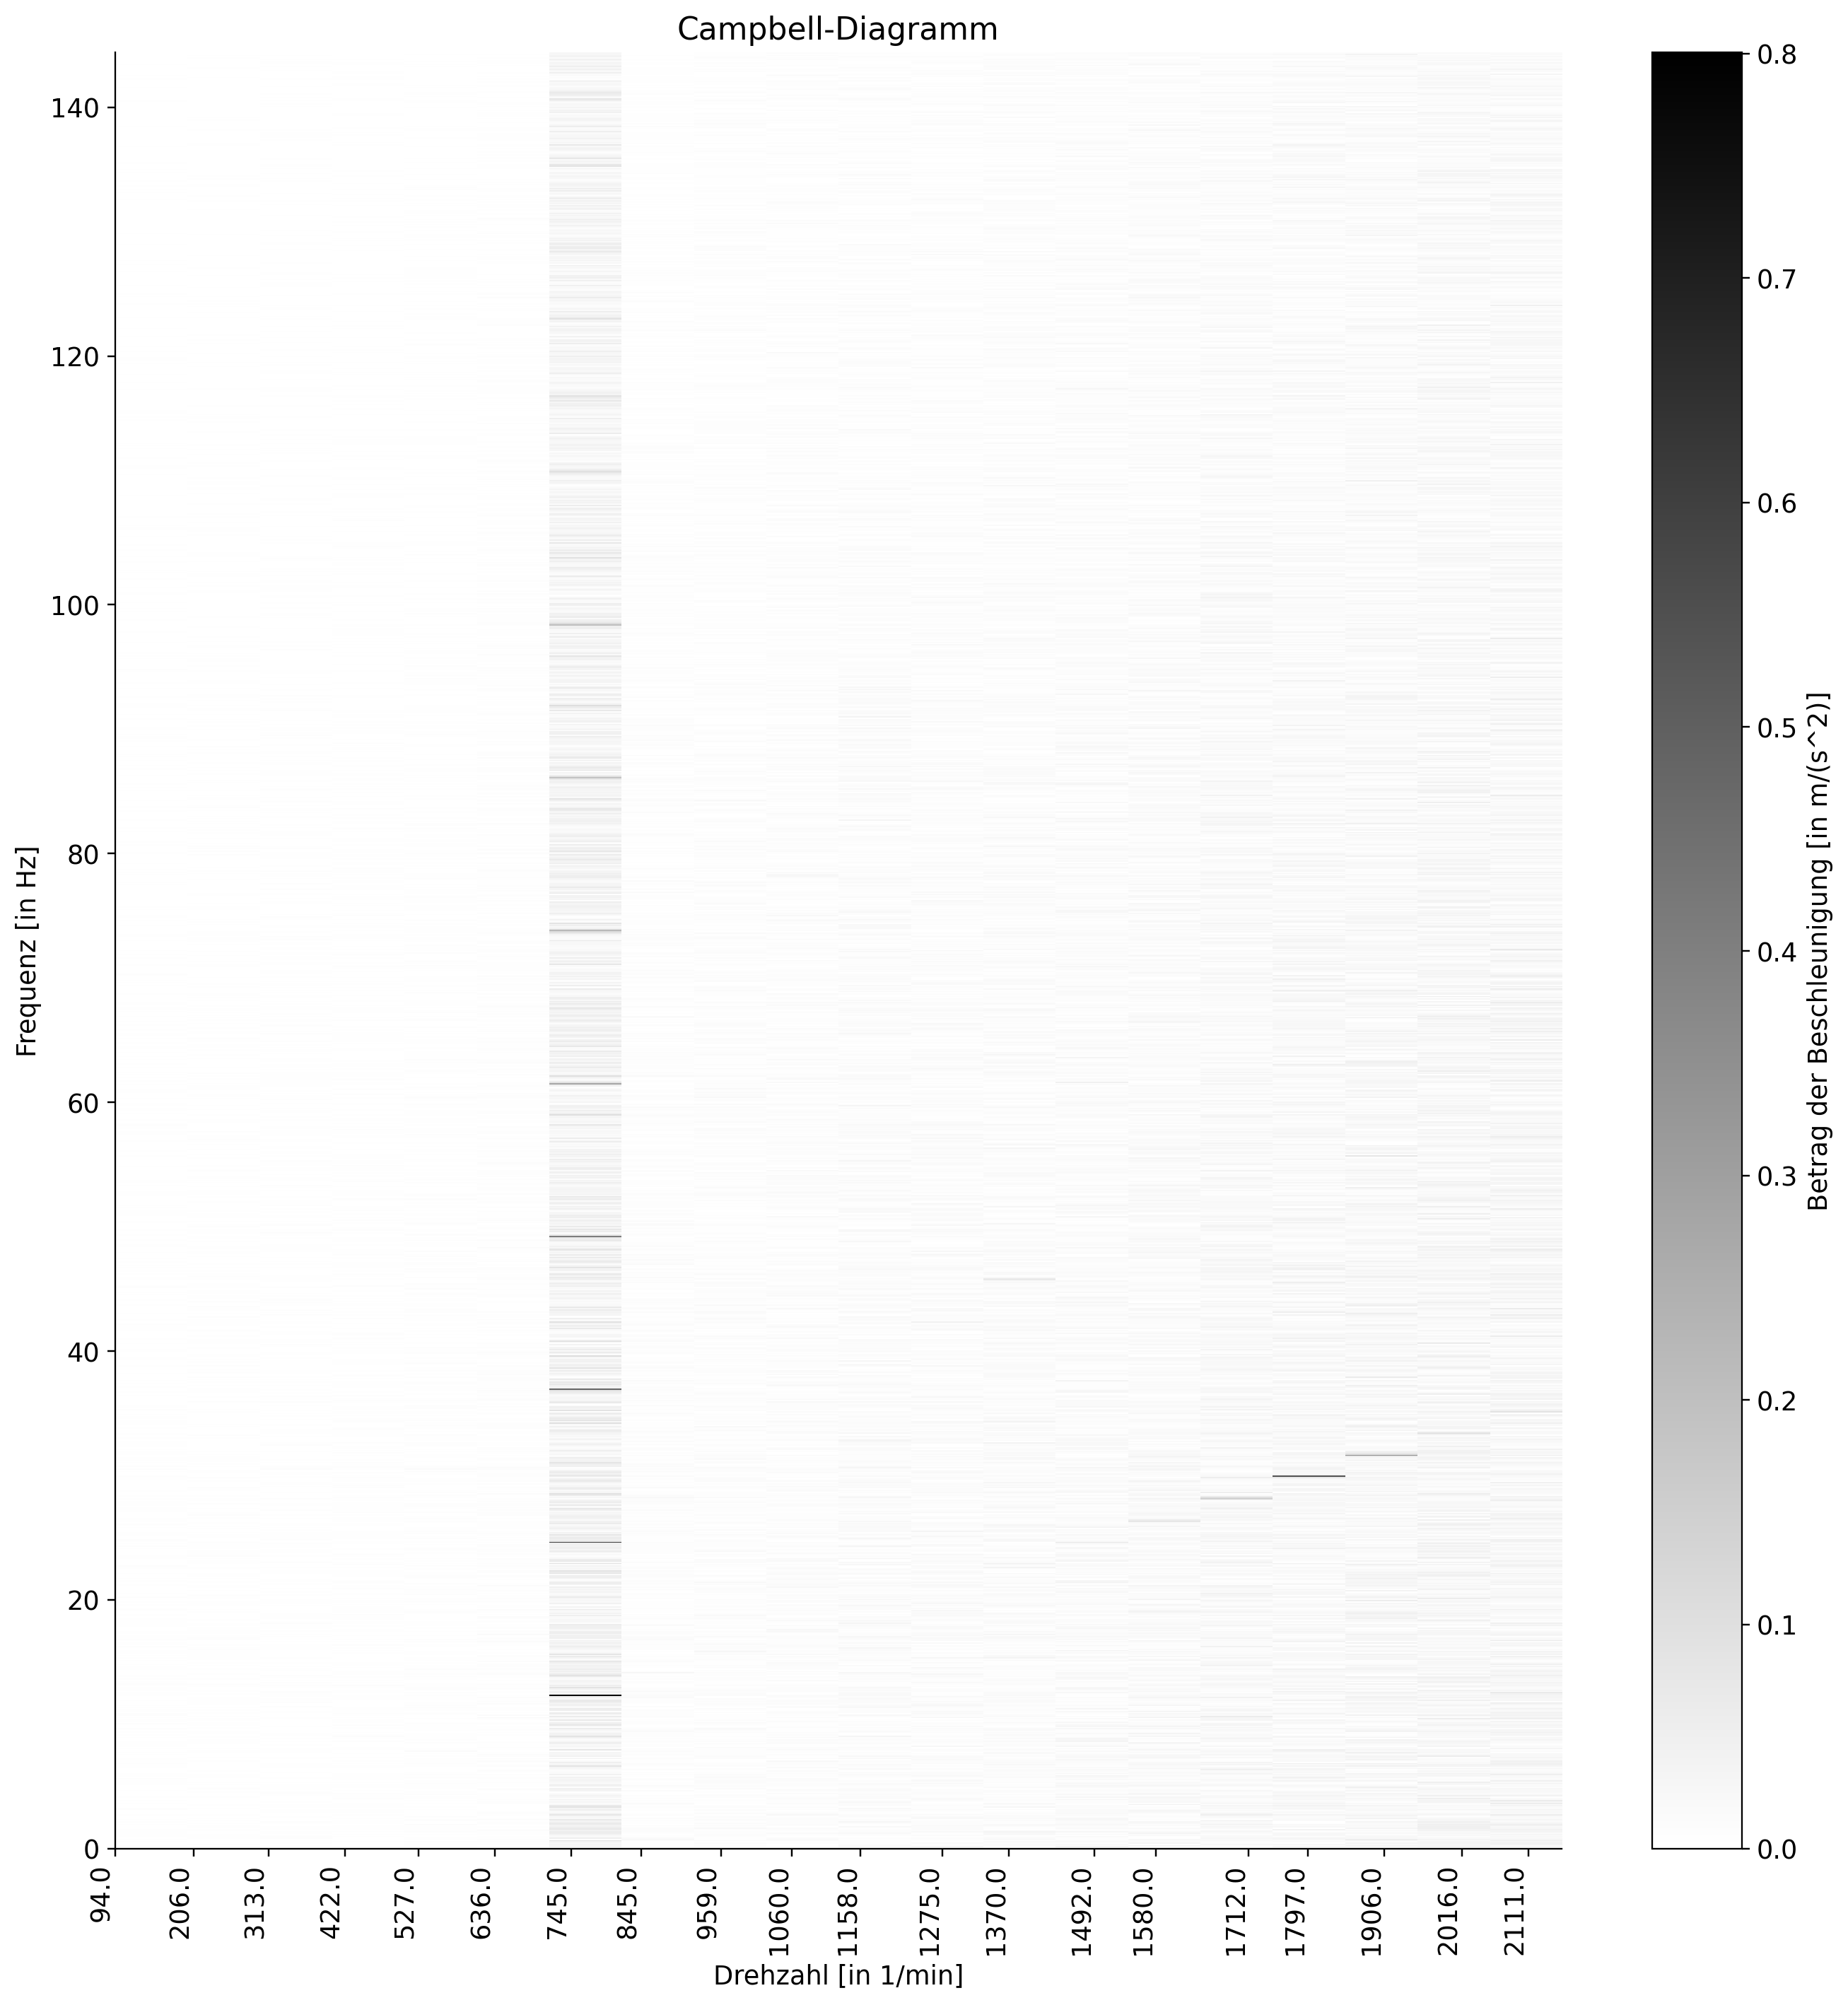

In [13]:
matrix = np.empty((len(data_list_3[1][1]),len(data_list_3)))
x_list = []
y_list = data_list_3[0][1]      

for i in range(len(data_list_3)):
    x_list.append(float(data_list_3[i][2]))
    for a in range(len(data_list_3[i][0])):
        matrix[a,i] = np.abs(data_list_3[i][0][a])
        
# Campbell-Diagramm plotten

fig, ax = plt.subplots(figsize=(15, 15))

extent = (min(x_list), x_list[-1] + (x_list[-1]-x_list[-2])/2, min(y_list), max(y_list))

plt.imshow(matrix,origin="lower", aspect="auto",interpolation="None",extent=extent,cmap="binary", vmin=matrix.min() ,vmax=matrix.max())

ax.set_xticks(x_list)
ax.set_xticklabels(x_list, rotation=90, ha='right')

plt.xlabel('Drehzahl [in 1/min]')
plt.ylabel('Frequenz [in Hz]')
plt.title("Campbell-Diagramm")
cbar=plt.colorbar()
cbar.set_label('Betrag der Beschleunigung [in m/(s^2)]')
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Anhand des ersten Campbelldiagramms lässt es sich erkennen, dass die kritische Drehzahl zwischen 1220 upm und 1389 upm liegt, während hingegen unserer theoretisch ermittelter Wert bei 1061 upm liegt. Somit kann zum dem Entschluss gekommen werden, dass der theoretische Wert eine relative große Abweichung zu dem Wert in der Praxis hat und demnach experimentelle Daten große Relevanz haben und man sich nicht nur auf den theoretischen Wert verlassen sollte, wenn man Bauteile auslegen möchte etc.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
siehe oben

## Fazit
Die ermittelten Differenzen bei der kritischen Drehlzahl können durch verschiedene Faktoren bedingt sein. Hierzu würden Ungenauigkeiten in den Materialdaten gehören aber auch in den Messdaten durch Toleranzen der Messinstrumente oder eine verschlissenes Lager, dass die Schwingungen der Welle verändert und den kritischen Drehzahlbereich verschiebt.